<a href="https://colab.research.google.com/github/acollin19/comp551_A1/blob/main/assignment1_group_24.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 1

## Process:
### Dataset 1: Hepatitis
* Task 1 : Preprocessing
    1. Implemenmting KNN Class
    2. Preprocessing
    3. Distributions
* Task 2 : Running KNN and DT
    1. KNN
    2. DT
* Task 3 : Running Experiments
    1. Compare accuracy
    2. Different K values
    3. Max tree depth
    4. Different distance/costs
    5. Plots
    6. Key features in DT
    7. Key features in KNN

### Dataset 2: Messidor features
* Task 1 : Preprocessing
    1. Preprocessing
    2. Distributions
* Task 2 : Running KNN and DT
    1. KNN
    2. DT
* Task 3 : Running Experiments
    1. Compare accuracy
    2. Different K values
    3. Max tree depth
    4. Different distance/costs
    5. Plots
    6. Key features in DT
    7. Key features in KNN


In [49]:
import pandas as pd
import numpy as np
import math
from math import sqrt
from sklearn.model_selection import train_test_split
import scipy.spatial
from scipy.io import arff
from collections import Counter
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
np.random.seed(1)

## Task 1.1 : Implementing KNN Class

In [50]:
# Modified class collab KNN implemetation 
euclidean = lambda x1, x2: np.sqrt(np.sum((x1 - x2)**2, axis=-1))
manhattan = lambda x1, x2: np.sum(np.abs(x1 - x2), axis=-1)

class KNN:

    def __init__(self, K=1, dist_fn= euclidean):
        self.dist_fn = dist_fn
        self.K = K
        return
    
    def fit(self, x, y):
        ''' Store the training data using this method as it is a lazy learner'''
        self.x = x
        self.y = y
        self.C = np.max(y) + 1
        return self
    
    def predict(self, x_test):
        ''' Makes a prediction using the stored training data and the test data given as argument'''
        num_test = x_test.shape[0]
        distances = self.dist_fn(self.x[None,:,:], x_test[:,None,:])
        #ith-row of knns stores the indices of k closest training samples to the ith-test sample 
        knns = np.zeros((num_test, self.K), dtype=int)
        #ith-row of y_prob has the probability distribution over C classes
        y_prob = np.zeros((num_test, self.C))
        for i in range(num_test):
            knns[i,:] = np.argsort(distances[i])[:self.K]
            y_prob[i,:] = np.bincount(self.y[knns[i,:]], minlength=self.C) #counts the number of instances of each class in the K-closest training samples
        #simply divide by K to get a probability distribution
        y_prob /= self.K
        return y_prob, knns

    # # Evaluating prediction accuracy on true and target labels
    def evaluate_acc(self, X_test, y_test, y_train,X_train ):
        #test accuracy
        y_test_prob, knns = self.fit(X_train, y_train).predict(X_test)
        y_test_pred = np.argmax(y_test_prob, axis=-1)
        test_acc = np.sum(y_test_pred == y_test)/y_test.shape[0]

        #train accuracy  
        y_train_prob, knns = self.fit(X_train, y_train).predict(X_train)
        y_train_pred = np.argmax(y_train_prob, axis=-1)
        acc_train = np.sum(y_train_pred==y_train)/y_train.shape[0]

        return (test_acc, acc_train)

## Task 1.2 : Preprocessing

In [51]:
# Loading/cleaning datasets

hepatitis = pd.read_csv("hepatitis.data", header=None)
hepatitis = hepatitis[(hepatitis != '?').all(axis=1)]
hepatitis = hepatitis.dropna().reset_index(drop=True)
hepatitis = hepatitis.apply(pd.to_numeric)
hepatitis.columns = ['CLASS','AGE','SEX','STEROID','ANTIVIRAL','FATIGUE','MALAISE','ANOREXIA',
            'LIVER BIG','LIVER FIRM','SPLEEN PALPABLE','SPIDERS','ASCITES','VARICES',
            'BILIRUBIN','ALK PHOSPHATE','SGOT','ALBUMIN','PROTIME','HISTOLOGY']
hepatitis.head()

,CLASS,AGE,SEX,STEROID,ANTIVIRAL,FATIGUE,MALAISE,ANOREXIA,LIVER BIG,LIVER FIRM,SPLEEN PALPABLE,SPIDERS,ASCITES,VARICES,BILIRUBIN,ALK PHOSPHATE,SGOT,ALBUMIN,PROTIME,HISTOLOGY
0,2,34,1,2,2,2,2,2,2,2,2,2,2,2,0.9,95,28,4.0,75,1
1,2,39,1,1,1,2,2,2,1,1,2,2,2,2,1.3,78,30,4.4,85,1
2,2,32,1,2,1,1,2,2,2,1,2,1,2,2,1.0,59,249,3.7,54,1
3,2,41,1,2,1,1,2,2,2,1,2,2,2,2,0.9,81,60,3.9,52,1
4,2,30,1,2,2,1,2,2,2,1,2,2,2,2,2.2,57,144,4.9,78,1


## Task 1.3 : Distributions

In [52]:
# Hepatitis Dataset
X = hepatitis.iloc[:, hepatitis.columns != 0].values # x -> features (1-19)
y = hepatitis.iloc[:, 0].values # y -> class label (0)

In [53]:
# Split Training and Testing with sklearn
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=1, shuffle=True)
print("Total Number of rows in train:",X_train.shape[0])
print("Total Number of rows in test:",X_test.shape[0])

Total Number of rows in train: 64
Total Number of rows in test: 16


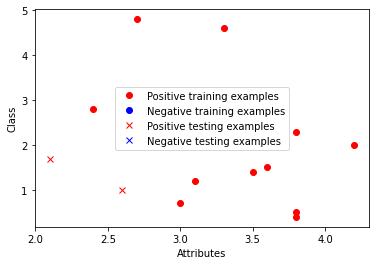

<Figure size 432x288 with 0 Axes>

In [54]:
plt.clf()
positive_train = y_train==1
negative_train = y_train==0

positive_test = y_test==1
negative_test = y_test==0

plt.plot(X_train[positive_train,17],X_train[positive_train,14],"or",label="Positive training examples")
plt.plot(X_train[negative_train,17],X_train[negative_train,14],"ob",label="Negative training examples")

plt.plot(X_test[positive_test,17],X_test[positive_test,14],"xr",label="Positive testing examples")
plt.plot(X_test[negative_test,17],X_test[negative_test,14],"xb",label="Negative testing examples")

plt.xlabel("Attributes")
plt.ylabel("Class")
plt.legend(loc='best')
plt.show()
plt.savefig("train_test_scatterplot.png", bbox_inches='tight', dpi=300)

## Task 2 : K-Nearest Neighbour


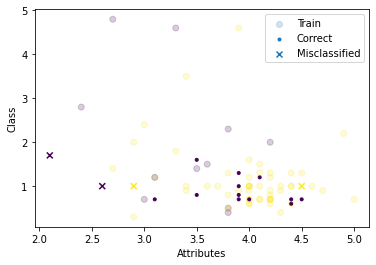

In [55]:
# Hepatitis KNN Plotting
K = 5
model = KNN(K)
y_prob, knns = model.fit(X_train, y_train).predict(X_test)
y_pred = np.argmax(y_prob, axis=-1)
correct = y_test == y_pred
incorrect = np.logical_not(correct)

#visualization of the points
plt.scatter(X_train[:,17], X_train[:,14], c=y_train, marker='o', alpha=.2, label='Train')
plt.scatter(X_test[correct,17], X_test[correct,14], marker='.', c=y_pred[correct], label='Correct')
plt.scatter(X_test[incorrect,17], X_test[incorrect,14], marker='x', c=y_test[incorrect], label='Misclassified')

plt.xlabel("Attributes")
plt.ylabel("Class")
plt.legend(loc='best')
plt.savefig("hepatitis_KNN.png", bbox_inches='tight', dpi=300)

In [56]:
# Evaluating prediction accuracy on training data
test_acc,train_acc = model.evaluate_acc(X_test,y_test,y_train, X_train)

print(f'Training Accuracy: {train_acc}')
print(f'Testing Accuracy: {test_acc}')


Training Accuracy: 0.84375
Testing Accuracy: 0.75


## Task 2.2 : Decision Trees

## Task 3.1 : Comparing Accuracy 

Using KNN: 
Testing accuracy is 0.5625  

Using Decision Trees: 

## Task 3.2 : Testing K values

Split the training data into 50% training data and 50% validation data.
The run the KNN through a loop to find the best K value.

best K = 9, test accuracy = 0.875


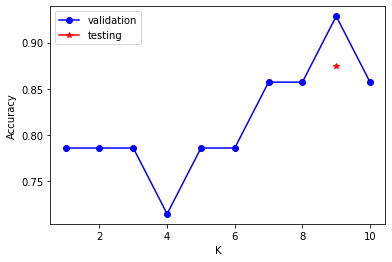

In [57]:
def best_k(X_train,y_train,X_test, y_test):
    # further split the training data into 50% training and 50% validation
    x_train_tr, y_train_tr = X_train[:50], y_train[:50]
    x_train_va, y_train_va = X_train[50:], y_train[50:]

    model_choices=[]
    valid_acc = []

    n_valid = y_train_va.shape[0]

    # Iterate through loop to find best K value
    for k in range(1,11):
        knn = KNN(K=k) 
        y_train_va_prob,_ = knn.fit(x_train_tr, y_train_tr).predict(x_train_va) 
        y_train_va_pred = np.argmax(y_train_va_prob,axis=-1)
        accuracy = np.sum(y_train_va_pred == y_train_va)/n_valid
        model_choices.append(k)
        valid_acc.append(accuracy)

    # use the best K to predict test data
    best_valid_K = model_choices[valid_acc.index(max(valid_acc))]
    knn = KNN(K=best_valid_K)
    y_test_prob,_ = knn.fit(X_train, y_train).predict(X_test)
    y_test_pred = np.argmax(y_test_prob, axis=-1)
    test_accuracy = np.sum(y_test_pred == y_test)/y_test.shape[0]

    return (model_choices,valid_acc,best_valid_K,test_accuracy)

model_choices,valid_acc,best_valid_K,test_accuracy = best_k(X_train,y_train,X_test, y_test)
print(f'best K = {best_valid_K}, test accuracy = {test_accuracy}')
plt.plot(model_choices, valid_acc, marker='o', color='blue', label='validation')
plt.plot(best_valid_K, test_accuracy, marker='*', color='red', label='testing')
plt.xlabel("K")
plt.ylabel("Accuracy")
plt.legend(loc='best')
plt.savefig('hepatitis_bestK.png',dpi=300,bbox_inches='tight')



## Task 3.3 : Maximum Tree Depth

## Task 3.4 : Testing Distance and Cost Functions

## Task 3.5 : Decision Boundary Plots

In [58]:
# #we can make the grid finer by increasing the number of samples from 200 to higher value
# x0v = np.linspace(np.min(X[:,0]), np.max(X[:,0]), 200)
# x1v = np.linspace(np.min(X[:,1]), np.max(X[:,1]), 200)

# # to features values as a mesh  
# x0, x1 = np.meshgrid(x0v, x1v)
# x_all = np.vstack((x0.ravel(),x1.ravel())).T

# for k in [1, 5, 15]:
#     print(k)
#     model = KNN(K=k)

#     y_train_prob = np.zeros((y_train.shape[0], C))
#     y_train_prob[np.arange(y_train.shape[0]), y_train] = 1
    
#     y_prob, knns = model.fit(X_train, y_train).predict(X_test)
#     y_pred = np.argmax(y_prob,axis=-1)    
#     correct = y_test == y_pred
#     incorrect = np.logical_not(correct)    
    
#     y_pred = np.argmax(y_prob,axis=-1)
#     accuracy = np.sum(y_pred == y_test)/y_test.shape[0]
#     acc = f'accuracy: {accuracy*100:.1f}.'
#     print(acc)
    

#     #to get class probability of all the points in the 2D grid
#     y_prob_all, _ = model.fit(X_train, y_train).predict(x_all)

#     y_pred_all = np.zeros_like(y_prob_all)
#     y_pred_all[np.arange(x_all.shape[0]), np.argmax(y_prob_all, axis=-1)] = 1    
    
#     plt.clf()
#     plt.scatter(X_train[:,0], X_train[:,1], c=y_train_prob, marker='o', alpha=1)
    
#     plt.scatter(x_all[:,0], x_all[:,1], c=y_pred_all, marker='.', alpha=0.01)
#     plt.ylabel('sepal length')
#     plt.xlabel('sepal width')
#     # plt.savefig('decision_boundaries_KNN'+str(k)+'.png', dpi=300, bbox_inches='tight') 
    
    
# plt.scatter(X_train[:,0], X_train[:,1], c=y_train_prob, marker='o', alpha=1)
# plt.scatter(x_all[:,0], x_all[:,1], c=y_prob_all, marker='.', alpha=.01)
# plt.ylabel('sepal length')
# plt.xlabel('sepal width')
# plt.show()

## Task 3.6 : Decision Tree Key Features


## Task 3.7 : KNN Key Feautures

# Dataset 2 : Messidor Features

## Task 1.1 Preprocessing

In [59]:
data = arff.loadarff('messidor_features.arff')
features = pd.DataFrame(data[0])
features.to_csv(index=False)
features = features[(features != '?').all(axis=1)]
features = features.dropna().reset_index(drop=True)
features = features.apply(pd.to_numeric)
features.columns = ["QUALITY", "PRESCREENING", "MA_1", "MA_2", "MA_3", "MA_4", "MA_5", "MA_6",
                    "EXUDATES_8", "EXUDATES_9", "EXUDATES_10", "EXUDATES_11", "EXUDATES_12", "EXUDATES_13", "EXUDATES_14", "EXUDATES_15",
                    "EUCLIDEAN_DIST", "OPTIC_DISC_DIAM", "AM_FM", "CLASS"]
features.head()


,QUALITY,PRESCREENING,MA_1,MA_2,MA_3,MA_4,MA_5,MA_6,EXUDATES_8,EXUDATES_9,EXUDATES_10,EXUDATES_11,EXUDATES_12,EXUDATES_13,EXUDATES_14,EXUDATES_15,EUCLIDEAN_DIST,OPTIC_DISC_DIAM,AM_FM,CLASS
0,1.0,1.0,22.0,22.0,22.0,19.0,18.0,14.0,49.895756,17.775994,5.270920,0.771761,0.018632,0.006864,0.003923,0.003923,0.486903,0.100025,1.0,0
1,1.0,1.0,24.0,24.0,22.0,18.0,16.0,13.0,57.709936,23.799994,3.325423,0.234185,0.003903,0.003903,0.003903,0.003903,0.520908,0.144414,0.0,0
2,1.0,1.0,62.0,60.0,59.0,54.0,47.0,33.0,55.831441,27.993933,12.687485,4.852282,1.393889,0.373252,0.041817,0.007744,0.530904,0.128548,0.0,1
3,1.0,1.0,55.0,53.0,53.0,50.0,43.0,31.0,40.467228,18.445954,9.118901,3.079428,0.840261,0.272434,0.007653,0.001531,0.483284,0.114790,0.0,0
4,1.0,1.0,44.0,44.0,44.0,41.0,39.0,27.0,18.026254,8.570709,0.410381,0.000000,0.000000,0.000000,0.000000,0.000000,0.475935,0.123572,0.0,1


## Task 1.2 Distributions

In [60]:
# Messidor features dataset
X = features.iloc[:,:-1].values # x -> features (0-18)
y = features.iloc[:,-1:].values # y -> class label (19)

inds_hep = np.random.permutation(X.shape[0])
X_train, y_train = X[inds_hep[:53]], np.ndarray.flatten(y[inds_hep[:53]])
X_test, y_test = X[inds_hep[53:]], np.ndarray.flatten(y[inds_hep[53:]])
# Split Training and Testing with sklearn
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=1, shuffle=True)


print("Total Number of rows in train:",X_train.shape[0])
print("Total Number of rows in test:",X_test.shape[0])

Total Number of rows in train: 53
Total Number of rows in test: 1098


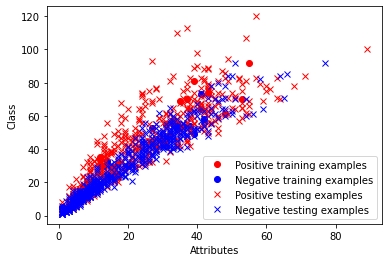

<Figure size 432x288 with 0 Axes>

In [61]:
plt.clf()
positive_train = y_train==1
negative_train = y_train==0

positive_test = y_test==1
negative_test = y_test==0

plt.plot(X_train[positive_train,7],X_train[positive_train,4],"or",label="Positive training examples")
plt.plot(X_train[negative_train,7],X_train[negative_train,4],"ob",label="Negative training examples")

plt.plot(X_test[positive_test,7],X_test[positive_test,4],"xr",label="Positive testing examples")
plt.plot(X_test[negative_test,7],X_test[negative_test,4],"xb",label="Negative testing examples")

plt.xlabel("Attributes")
plt.ylabel("Class")
plt.legend(loc='best')
plt.show()
plt.savefig("train_test_scatterplot.png", bbox_inches='tight', dpi=300)

## Task 2 : K-Nearest Neighbour

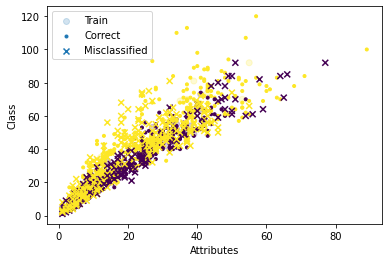

In [65]:
# Messidor KNN Plotting
K = 5
classifier = KNN(K)

y_prob, knns = classifier.fit(X_train, y_train).predict(X_test)
y_pred = np.argmax(y_prob, axis=-1)
correct = y_test == y_pred
incorrect = np.logical_not(correct)

#visualization of the points
plt.scatter(X_train[:,7], X_train[:,4], c=y_train, marker='o', alpha=.2, label='Train')
plt.scatter(X_test[correct,7], X_test[correct,4], marker='.', c=y_pred[correct], label='Correct')
plt.scatter(X_test[incorrect,7], X_test[incorrect,4], marker='x', c=y_test[incorrect], label='Misclassified')

plt.xlabel("Attributes")
plt.ylabel("Class")
plt.legend(loc='best')
plt.savefig("messidor_features_dist.png", bbox_inches='tight', dpi=300)

In [66]:
# Evaluating prediction accuracy on training data
test_acc,train_acc = classifier.evaluate_acc(X_test,y_test,y_train, X_train)

print(f'Training Accuracy: {train_acc}')
print(f'Testing Accuracy: {test_acc}')



Training Accuracy: 0.7735849056603774
Testing Accuracy: 0.5983606557377049


## Task 2.2 : Decision Trees

## Task 3.1 : Comparing Accuracy 


## Task 3.2 : Testing K values

Split the training data into 50% training data and 50% validation data.
The run the KNN through a loop to find the best K value.

best K = 10, test accuracy = 0.5728597449908925


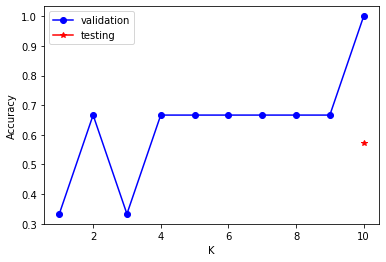

In [68]:
model_choices,valid_acc,best_valid_K,test_accuracy = best_k(X_train,y_train,X_test, y_test)
print(f'best K = {best_valid_K}, test accuracy = {test_accuracy}')
plt.plot(model_choices, valid_acc, marker='o', color='blue', label='validation')
plt.plot(best_valid_K, test_accuracy, marker='*', color='red', label='testing')
plt.xlabel("K")
plt.ylabel("Accuracy")
plt.legend(loc='best')
plt.savefig('messidor_bestK.png',dpi=300,bbox_inches='tight')

## Task 3.3 : Maximum Tree Depth

## Task 3.4 : Testing Distance and Cost Functions

## Task 3.5 : Decision Boundary Plots

## Task 3.6 : Decision Tree Key Features


## Task 3.7 : KNN Key Features
